# Clean data: drifters

To do:

- (tmp) analysis with drifters: 
    - [ ] maps of trajectories
    - [ ] trajectories in relative frame of reference
    - [ ] relative dispersion
    - [ ] produce movies of trajectories
    - [ ] produce movies of relative evolution


In [4]:
import os
from glob import glob

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import hvplot.pandas  # noqa

#
import pynsitu as pin
from pynsitu.maps import crs

from lib import raw_dir, root_dir, images_dir, KEYS

In [5]:
# drifters
campaign="drifters_CSWOT_BIOSWOT"
yaml = f"{campaign}.yaml"
cp = pin.Campaign(os.path.join(root_dir,yaml))

---

# process one trajectory for illustration

### Show raw speed distribution (for despiking purposes)

In [151]:
# CHOOSE DRIFTER TYPE
key = KEYS[3]

df = pd.read_csv(glob(os.path.join(raw_dir, key+'*'))[0], parse_dates = ['time'], dtype={"id":'string'}).set_index('id')
ids = df.index.unique()

ids_map = {p: cp[p]["serial_number"] for p in cp if  key in p}
ids_yaml = sorted(set([id for _, id in ids_map.items()]))
ids_imap = {v: k for k, v in ids_map.items()}

flag = set(ids).issuperset(ids_yaml)
if flag:
    print("Data file and campaign yaml file agree upon drifter ids")
else:
    assert False, "Data file and campaign yaml file do not agree upon drifter ids"

Data file and campaign yaml file agree upon drifter ids


In [152]:
key

'svp_ogs'

In [153]:
# CHOOSE DRIFTER

p, d = key+'_00', 'd0'
_id = cp[p]['serial_number']

df0 = (df.loc[_id].set_index("time").sort_index())
print(df0.index.min())

# trim before computing speed
df0 = df0.ts.trim(cp[p][d])
print(df0.index.min())

# compute speed
df0 = df0.geo.compute_velocities(keep_dt=True)
df0 = df0.geo.compute_accelerations()
df0["dt"].iloc[0] = np.NaN # drops first dt

# plot
df0.geo.plot_bokeh(velocity=True, acceleration=True)

2023-05-05 11:20:00
2023-05-06 13:30:00


Loading BokehJS ...

In [154]:
kwargs = dict(x="x", y="y", hover_cols=['time'])
_df = df0.reset_index()
(_df.hvplot(**kwargs, color="k", line_width=2)
*_df.hvplot.scatter(**kwargs, s=30, c="velocity").opts(clim=(0,1), cmap="magma")
).opts(show_grid=True)

:Overlay
   .Curve.I   :Curve   [x]   (y,time)
   .Scatter.I :Scatter   [x]   (y,velocity,time)

Notes:

Several kinds of errors: isolated errors, apparent "timing" error (nearby times with different positions)


### **step 1**: drops positions that are too close (less than 1 minute apart)

Pairs of points may be seperated by less than a minute.

Should we drop early or late data point?
We choose to drop the early point which seems to be associated with an earlier point

**Nearby positions allways seem to follow an extended time period without positions - verify !!**


In [155]:
dt_nearby_threshold = df0.dt.median()/60*0.5 # in minutes
print(f'dt_lim:{dt_nearby_threshold}')
df_bad = df0.loc[df0["dt"]<60*dt_nearby_threshold]
frac_full = (df_bad.index.size)/df.index.size
print(f"fraction of nearby data for the full dataset = {frac_full*100:.3f}%")

n_bad = df_bad.index.size
n_bad

dt_lim:5.0
fraction of nearby data for the full dataset = 0.000%


0

In [156]:
def plot_target_time(df, t, dt=None):
    if dt is None:
        dt = pd.Timedelta("20T")
    elif isinstance(dt, str):
        dt = pd.Timedelta(dt)

    df = df.loc[ (df.index>t-dt) & (df.index<t+dt)].copy()
    df.loc[:,"x"] = df.loc[:,"x"]-df["x"].mean()
    df.loc[:,"y"] = df.loc[:,"y"]-df["y"].mean()

    tm = df.loc[ df.index<t ].index[-1]
    
    fig, axes = plt.subplots(1,3, figsize=(10,3))
    #
    ax = axes[0]
    ax.plot(df["x"], df["y"], "k")
    ms = 50
    ax.scatter(df.loc[tm, "x"], df.loc[tm, "y"], 2*ms, marker="p", color="orange")
    ax.scatter(df.loc[t, "x"], df.loc[t, "y"], 2*ms, marker="p", color="red")
    ax.scatter(df["x"], df["y"], ms, marker="x")
    ax.scatter(df.iloc[0]["x"], df.iloc[0]["y"], 2*ms, marker="o", color="cadetblue")
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()
    #
    ax = axes[1]
    kwargs = dict(ax=ax, ls="-", marker="+")
    ax.scatter(df.index[0], df.iloc[0]["velocity"], 2*ms, marker="o", color="cadetblue")
    df["velocity_east"].plot(**kwargs)
    df["velocity_north"].plot(**kwargs)
    df["velocity"].plot(**kwargs, color="k")
    ax.scatter(tm, df.loc[tm, "velocity"], 2*ms, marker="p", color="orange")
    ax.scatter(t, df.loc[t, "velocity"], 2*ms, marker="p", color="red")
    ax.set_ylabel('Velocities')
    ax.grid()
    #
    ax = axes[2]
    kwargs = dict(ax=ax, ls="-", marker="+")
    ax.scatter(df.index[0], df.iloc[0]["acceleration"], 2*ms, marker="o", color="cadetblue")
    df["acceleration_east"].plot(**kwargs, label = 'east')
    df["acceleration_north"].plot(**kwargs, label = 'north')
    df["acceleration"].plot(**kwargs, color="k", label='norm')
    ax.scatter(tm, df.loc[tm, "acceleration"], 2*ms, marker="p", color="orange")
    ax.scatter(t, df.loc[t, "acceleration"], 2*ms, marker="p", color="red")
    ax.set_ylabel('Accelerations')
    ax.legend()
    ax.grid()
    fig.tight_layout()

In [157]:
def plot_target_time(df, t, dt=None, orange=True):
    if dt is None:
        dt = pd.Timedelta("40T")
    elif isinstance(dt, str):
        dt = pd.Timedelta(dt)

    df = df.loc[ (df.index>t-dt) & (df.index<t+dt)].copy()
    df.loc[:,"x"] = df.loc[:,"x"]-df["x"].mean()
    df.loc[:,"y"] = df.loc[:,"y"]-df["y"].mean()

    tm = df.loc[ df.index<t ].index[-1]
    
    fig, axes = plt.subplots(1,2, figsize=(6,3))
    #
    ax = axes[0]
    ax.plot(df["x"], df["y"], "k")
    ms = 50
    if orange == True :
        ax.scatter(df.loc[tm, "x"], df.loc[tm, "y"], 2*ms, marker="p", color="orange")
    ax.scatter(df.loc[t, "x"], df.loc[t, "y"], 2*ms, marker="p", color="red")
    ax.scatter(df["x"], df["y"], ms, marker="x")
    ax.scatter(df.iloc[0]["x"], df.iloc[0]["y"], 2*ms, marker="o", color="cadetblue")
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.grid()
    #
    ax = axes[1]
    kwargs = dict(ax=ax, ls="-", marker="+")
    ax.scatter(df.index[0], df.iloc[0]["y"], 2*ms, marker="o", color="cadetblue")
    df["y"].plot(**kwargs)
    if orange == True :
        ax.scatter(tm, df.loc[tm, "y"], 2*ms, marker="p", color="orange")
    ax.scatter(t, df.loc[t, "y"], 2*ms, marker="p", color="red")
    ax.set_ylabel('y [m]')
    ax.grid()
    fig.suptitle(df.dt.loc[t])
    fig.tight_layout()
    return fig

In [158]:
fig.save?

Object `fig.save` not found.


In [159]:
for t in df_bad[df_bad.dt>4*60].index[:10]:
    fig = plot_target_time(df0, t)
fig.savefig(os.path.join(images_dir, 'ex_nearby_time.png'))

In [96]:
def drop_nearby_times(df, dt_threshold):
    """ Find pairs of neighboring times and drop the first time from dataframe
    
    Parameters
    ----------
    df: pd.DataFrame
    dt_thresdhold: int, float
        Threshold defining nearby times in minutes
    Returns
    -------
    df: pd.DataFrame
        Cleaned dataframe
    """
    
    # find nearby times
    df_bad = df.loc[df["dt"]<60*dt_threshold]
    print(f"{df_bad.index.size} neighboring times found ({dt_threshold} minutes threshold)")
    
    # drop
    df = df.drop([df.loc[ df.index<t ].index[-1] for t in df_bad.index])
    
    # update velocity
    df = df.geo.compute_velocities(keep_dt=True)
    df = df.geo.compute_accelerations()

    return df

In [97]:
df1 = drop_nearby_times(df0, dt_nearby_threshold)

27 neighboring times found (2 minutes threshold)


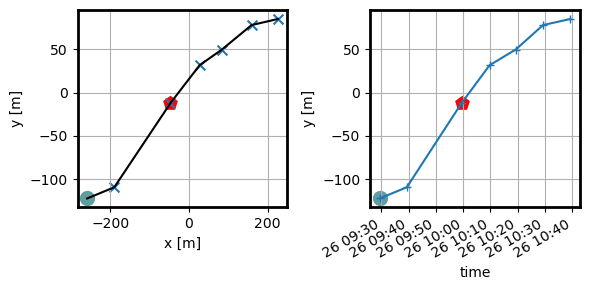

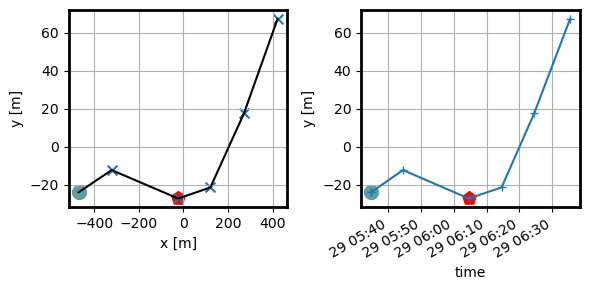

In [104]:
for t in df_bad.index[:2]:
    fig = plot_target_time(df1, t, orange=False)
fig.savefig(os.path.join(images_dir, 'ex_nearby_time_corrected.png'))

### **step 2** : manual editing of anomalous intervals

We are generous with time invervals to smooth errors as much as possible

In [ ]:
M = dict()
if campaign=="taos1_drifters0":
    M["drifter1"] = [slice("2022/11/17 17:02:40", "2022/12/01 00:00:00")]

In [ ]:
def manual_edit(df, M):
    for m in M:
        df = df.loc[ (df.index<m.start) | (df.index>m.stop) ]
    return df

if p in M:
    df2 = manual_edit(df1, M[p])
else:
    df2 = df1

# update velocity?
#df2 = df2.geo.compute_velocities(acceleration=True, keep_dt=True, centered=False)

### **step 3**: despike isolated anomalous values

This is based on anomalous acceleration values combined with acceleration adequate sign reversal (see `despike_isolated` doc)

0 m/s to 1 m/s over 3h is approx 1e-4, we are conservative and choose a looser threshold

In [ ]:
acceleration_threshold = 1e-3

df3 = pin.drifters.despike_isolated(df2, acceleration_threshold)

# plot
df3.geo.plot_bokeh(velocity=True, acceleration=True)

### **step 4**: smooth/interpolate time series

How can we objectively choose parameter values: `position_error`, `acceleration_amplitude`, `acceleration_T` ?

Could look at the sensitivity of histograms to these parameters or more global metrics (std)

In [ ]:
# remaining peaks are presumably jumps in positions and should be smoothed out
# interpolate along the way

position_error = 100
acceleration_amplitude = 2*1e-4 # m/s^2
acceleration_T = 3600*3 # less effect than acceleration_amplitude in smoothing acceleration
dt = "1T"

t_target = pd.date_range(
    cp[p][d].start.time.floor(dt),
    cp[p][d].end.time.ceil(dt),
    freq=dt,
)

df4 = pin.drifters.resample_smooth(
    df3, t_target, position_error, acceleration_amplitude, acceleration_T,
)
# velocity/acceleration are updated by default

In [ ]:
kwargs = dict(x="x", y="y", hover_cols=['time'])

_df = df4.reset_index()
_df0 = df0.reset_index()

(_df.hvplot(**kwargs, color="k", line_width=2)
*_df.hvplot.scatter(**kwargs, s=30, c="velocity").opts(clim=(0,1), cmap="magma")
*_df0.hvplot.scatter(**kwargs, s=10, c="cadetblue")
).opts(show_grid=True)

In [ ]:
# 'CartoLight', 'EsriNatGeo', 'EsriTerrain'
#kwargs = dict(x="longitude", y="latitude", hover_cols=['time'], geo=True, tiles='EsriStreet', frame_width=400, frame_height=400)
kwargs = dict(x="longitude", y="latitude", hover_cols=['time'], geo=True)


# tiles are not working here anymore ... bug with current version of hvplot or geoviews - minimal example ?
(
_df.hvplot.points(**kwargs, color="k", frame_width=500, frame_height=400) # tiles='CartoLight'
*_df.hvplot.points(**kwargs, s=100, c="velocity", clim=(0,1), cmap="magma")
*_df0.hvplot.points(**kwargs, s=10, c="cadetblue")
).opts()

In [ ]:
df4.geo.plot_bokeh(velocity=True, acceleration=True)

In [ ]:
kwargs = dict(frame_width=300, grid=True)
(df1["velocity_north"].hvplot(**kwargs) * df4["velocity_north"].hvplot(**kwargs)
+ df1["velocity_east"].hvplot(**kwargs) * df4["velocity_east"].hvplot(**kwargs)
+ df1["velocity"].hvplot(**kwargs) * df4["velocity"].hvplot(**kwargs)
+ df1["acceleration"].hvplot(**kwargs) * df4["acceleration"].hvplot(**kwargs)
).cols(2)

---
## apply to all drifter and deployments

In [ ]:
D, D0 = [], []
for p, i in ids_map.items():
    for _, d in cp[p]["deployments"].items():

        print("---- {} {} {} {:.1f} days".format(p, d.label, i, d["duration_days"]))
        
        # trim
        df0 = df.loc[i].set_index("time").sort_index()
        df0 = df0.ts.trim(d)
        df0["deployment"] = d.label
        df0["id"] = i
        df0["platform"] = p
        
        # compute speed/acceleration
        df0.geo.compute_velocities(keep_dt=True, inplace=True)
        df0.geo.compute_accelerations(inplace=True)
        df0["dt"].iloc[0] = np.NaN # drops first dt
        D0.append(df0) # will serve as starting dataset
        
        # remove timing errors
        df1 = drop_nearby_times(df0, dt_nearby_threshold)
        
        # apply manual editing
        if p in M:
            df2 = manual_edit(df1, M[p])
        else:
            df2 = df1
        
        # despike
        df3 = pin.drifters.despike_isolated(df2, acceleration_threshold)
        
        # smooth/interpolate
        t_target = pd.date_range(d.start.time.floor(dt), d.end.time.ceil(dt), freq=dt)
        df4 = pin.drifters.resample_smooth(
            df3, t_target, position_error, acceleration_amplitude, acceleration_T
        )
        
        # fills in relevant met data
        start = df4.iloc[0][["longitude", "latitude"]]
        end = df4.iloc[-1][["longitude", "latitude"]]
        print(f"start = {start.name}  {start.longitude:.4f}  {start.latitude:.4f}")
        print(f"end = {end.name}  {end.longitude:.4f}  {end.latitude:.4f}")
        D.append(df4)

df_clean = pd.concat(D, axis=0).reset_index().set_index("id")
df_trim = pd.concat(D0, axis=0).reset_index().set_index("id")

df_clean.head()

### store

In [ ]:
df_clean.to_xarray().to_netcdf(os.path.join(cp["path_processed"], "drifters.nc"), mode="w")

---

## compare raw vs clean distributions of velocity and acceleration


In [ ]:
def compare_histograms(v, units, bins_zoomed, log=False):
    fig, axes = plt.subplots(1, 2, figsize=(8,3))
    ax = axes[0]
    bins = 20
    df_trim[v].plot.hist(ax=ax, bins=bins, alpha=0.5, label="raw")
    df_clean[v].plot.hist(ax=ax, bins=bins, alpha=0.5, label="clean")
    if log:
        ax.set_yscale("log")
    ax.set_xlabel(units)
    ax.grid()
    ax.set_title("full, raw mean = {:.2e}, smoothed mean = {:.2e} ".format(df_trim[v].mean(), df_clean[v].mean()))
    ax.legend()
    #
    ax = axes[1]
    bins = bins_zoomed
    df_trim[v].plot.hist(ax=ax, bins=bins, alpha=0.5)
    df_clean[v].plot.hist(ax=ax, bins=bins, alpha=0.5)
    if log:
        ax.set_yscale("log")
    ax.set_xlabel(units)
    ax.grid()
    ax.set_title("zoomed")

In [ ]:
compare_histograms("velocity", "[m/s]", np.arange(0, 2, 0.02))
compare_histograms("acceleration", "[m/s]", np.arange(0, 5*1e-4, 5e-6))

## Other potentially useful plots

### timeseries

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in ids_yaml:
    df_clean.loc[i].set_index("time")["velocity"].plot(
        label=i
    )  # x="longitude", y="latitude"
ax.legend()
ax.grid()

### overview map of the trajectories

In [ ]:
#bounds=[-.5, -.1, 49.25, 49.5]
if campaign=="taos2_drifters0":
    bounds=[-.4, .0, 49.25, 49.4] # taos0-drifters0
elif campaign=="taos2_drifters1":
    bounds=[-.4, -.8, 49.27, 49.42] # taos0-drifters1

_df = df_clean.reset_index().set_index(["id", "deployment"])
    
fig, ax, cbar = cp.map(extent=bounds)

keys = _df.groupby(_df.index).groups.keys()
colors = pin.get_cmap_colors(len(keys))

for k, c in zip(keys, colors):
    _dfk = _df.groupby(_df.index).get_group(k).reset_index().dropna(axis=1)
    ax.plot(_dfk.longitude, _dfk.latitude, color=c, transform=crs, label=", ".join(k))
    ax.scatter(_dfk.longitude.iloc[0], _dfk.latitude.iloc[0], color=c, transform=crs,
            edgecolor="k", s=100, zorder=10, marker="o",
           )
    ax.scatter(_dfk.longitude.iloc[-1], _dfk.latitude.iloc[-1], color=c, transform=crs,
            edgecolor="k", s=200, zorder=10, marker="*",
           )

ax.legend()

---

## inspecting displacement increments:


Should be developped further, potentially useful to quantify the position noise level.

Need to add reference velocity lines.

In [ ]:
def dtdl_hist(df):
    # copy and project
    df = df.copy()
    df.geo.project()

    # define bins
    dt_bins = np.arange(0, 20, 0.5)  # in minutes
    dl_bins = np.arange(0, 2000, 50)  # in m

    # compute time and space steps
    df["dt"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["time"].diff() / pd.Timedelta("1m"))
        .droplevel(0)
    )
    df["dx"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["x"].diff())
        .droplevel(0)
    )
    df["dy"] = (
        df.groupby(df.index)
        .apply(lambda _df: _df.sort_values("time")["y"].diff())
        .droplevel(0)
    )
    df["dl"] = np.sqrt(df.dx**2 + df.dy**2)

    # cut prior to grouping
    df["dt_cut"] = pd.cut(df.dt, dt_bins)
    df["dl_cut"] = pd.cut(df.dl, dl_bins)
    # count
    dfc = df.groupby(["dt_cut", "dl_cut"]).count()["dx"].reset_index()
    # massage and convert to xarray
    dfc.loc[:, ["dt", "dl"]] = dfc.apply(
        lambda row: pd.Series(dict(dt=row["dt_cut"].left, dl=row["dl_cut"].left)),
        axis=1,
    )
    da = dfc.set_index(["dt", "dl"])["dx"].to_xarray().rename("count")
    da = da.where(da > 0)

    return da


da = dtdl_hist(df)
da.plot()

fig, ax = plt.subplots(1, 1)
da.isel(dt=0).plot()

At lag 0, the mode of the spatial spacing is 200m.

Velocity associated with a 300m error over 10 minutes:

In [ ]:
dl = 200  # meters
dt = 10  # minutes
print(f"speed error={dl/(dt*60):.2f} m/s for dt={dt} min and dl={dl} m")